In [1]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
import anndata as ad
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import scanpy as sc

# 01 - Load model

In [2]:
import pickle  # or use joblib

adata=ad.read_h5ad('/home/local.hcpa.ufrgs.br/tkruger/V02_Glioblastoma_atlas/adatas/adata.h5ad')

with open("final_xgb_model_20250504_025832.pkl", "rb") as f:
    model = pickle.load(f)

importance = model.feature_importances_
feature_names = adata.var_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

importance_df

adatab=ad.read_h5ad('/home/local.hcpa.ufrgs.br/tkruger/V02_Glioblastoma_atlas/adatas/adata_5.h5ad')

#Make row names unique
adata.obs_names_make_unique()
adatab.obs_names_make_unique()

#Find intersections between adatas
match = np.intersect1d(adata.obs_names, adatab.obs_names)

#Keep adata matrix with obs that are in adatab
adata = adata[match]

#Map classes from adatab to adata
adata.obs['broad_cell_type'] = adata.obs.index.map(adatab.obs['broad_cell_type'])

/home/local.hcpa.ufrgs.br/tkruger/Install/conda/miniconda3/envs/ML/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_342186/254197543.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['broad_cell_type'] = adata.obs.index.map(adatab.obs['broad_cell_type'])


In [3]:
importance_df

,Feature,Importance
12700,TYROBP,0.129359
1136,SRGN,0.101736
12861,CD52,0.058507
9122,PPP1R14A,0.050264
5291,PLP1,0.028795
...,...,...
5554,MFAP1,0.000000
5555,B4GALT1,0.000000
5556,TRMT13,0.000000
5557,SIRT5,0.000000


In [17]:
adata.obsm["X_umap"] = adatab.obsm["X_umap"].copy()

/tmp/ipykernel_282676/3629797591.py:1: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  adata.obsm["X_umap"] = adatab.obsm["X_umap"].copy()


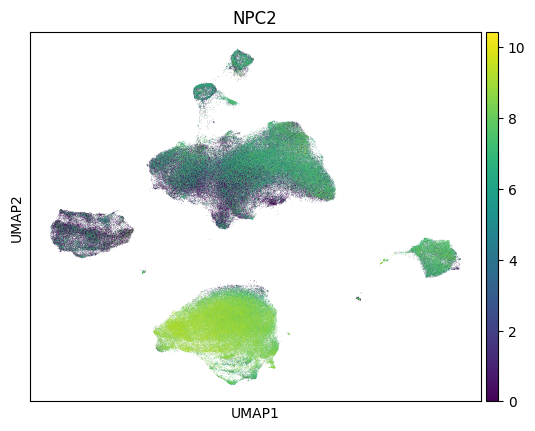

In [51]:
sc.pl.umap(adatab, color='NPC2')

# 02 - Remove half of the features

In [57]:
remove = importance_df.tail(6556)['Feature']

In [61]:
adata.shape

(307138, 13112)

In [65]:
adata = adata[:, ~adata.var_names.isin(remove)]

In [66]:
adata.shape

(307138, 6556)

In [67]:
adata.obs

,barcodes,author,sample,tissue,tumor_status,age,sex,region,IDH-1_status,MGMT_status,...,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,outlier,mt_outlier,doublet_scores,predicted_doublets,broad_cell_type
1000_3,1000_3,YUAN_2018,YUAN_2018_3,TUMORAL,PRIMARY,65,MALE,Temporal/Left,WT,NA,...,5.673323,11.218569,0.0,0.000000,0.000000,False,False,0.045610,False,Tumoral
1000_6,1000_6,YUAN_2018,YUAN_2018_6,TUMORAL,RECURRENT,50,MALE,Temporal/Left,WT,NA,...,5.703782,20.634921,0.0,0.000000,0.000000,False,False,0.012451,False,Tumoral
1000_7,1000_7,YUAN_2018,YUAN_2018_7,TUMORAL,PRIMARY,59,MALE,Parietal/Right,WT,NA,...,5.598422,12.260711,0.0,0.000000,0.000000,False,False,0.046632,False,Tumoral
1001_3,1001_3,YUAN_2018,YUAN_2018_3,TUMORAL,PRIMARY,65,MALE,Temporal/Left,WT,NA,...,6.124683,17.647059,1.0,0.693147,0.038700,False,False,0.034729,False,Tumoral
1001_6,1001_6,YUAN_2018,YUAN_2018_6,TUMORAL,RECURRENT,50,MALE,Temporal/Left,WT,NA,...,5.318120,14.019337,0.0,0.000000,0.000000,False,False,0.030097,False,Myeloid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZHAO_2020_TTTTGAGTAGAG,TTTTGAGTAGAG,ZHAO_2020,ZHAO_2020_2,TUMORAL,PRIMARY,61,MALE,Frontal/Left,WT,NA,...,4.820282,8.367347,8.0,2.197225,0.544218,False,False,0.064665,False,Myeloid
ZHAO_2020_TTTTTCTCTCTT,TTTTTCTCTCTT,ZHAO_2020,ZHAO_2020_2,TUMORAL,PRIMARY,61,MALE,Frontal/Left,WT,NA,...,4.875197,7.733492,3.0,1.386294,0.178465,False,False,0.060000,False,Myeloid
ZHAO_2020_TTTTTCTGTCAG,TTTTTCTGTCAG,ZHAO_2020,ZHAO_2020_3,TUMORAL,PRIMARY,61,MALE,Frontal/Left,WT,NA,...,5.891644,17.215069,0.0,0.000000,0.000000,False,False,0.111465,False,Tumoral
ZHAO_2020_TTTTTGGAAGCA,TTTTTGGAAGCA,ZHAO_2020,ZHAO_2020_2,TUMORAL,PRIMARY,61,MALE,Frontal/Left,WT,NA,...,4.736198,6.815440,7.0,2.079442,0.422195,False,False,0.075188,False,Tumoral


In [68]:
#Extract adata matrix
X = adata.X

In [69]:
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X

In [70]:
#Extract classes
y = adata.obs['broad_cell_type']

In [71]:
df = pd.DataFrame({'label': y.values})

In [72]:
#Save matrices and labels of train and test
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')

# 03 - Define Model

In [73]:
# Best params:
best_learning_rate = 0.22959818254342154
best_max_depth = 7
best_n_estimators = 70

In [74]:
#Define model
model = XGBClassifier(
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=1,
    verbosity=1
)


# 04 - Data split

In [75]:
#Divide dataset into train and test keeping proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
#Convert matrices to dense
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [83]:
#Get rows sums
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)

In [87]:
#Normalize both matrices using row sums and scaling to 1000k counts
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000

In [88]:
#Apply log1p to normalized counts
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)

In [89]:
#Apply scaler for mean = 0
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)

In [90]:
#Save tuning subset
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

In [ ]:
# Keep all features

In [ ]:
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 50% of features

In [3]:
remove = importance_df.tail(6556)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# 05 - Remove 75% of the features

In [5]:
remove = importance_df.tail(9834)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 82,5% of features

In [3]:
remove = importance_df.tail(11473)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 93.75 of features

In [9]:
remove = importance_df.tail(12292)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 96.8% of features

In [7]:
remove = importance_df.tail(12702)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 98.4% of features

In [11]:
remove = importance_df.tail(12907)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 98,8% of features

In [14]:
remove = importance_df.tail(13010)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

# Remove 99.6% of features

In [7]:
remove = importance_df.tail(13061)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

/tmp/ipykernel_282676/1128661756.py:18: RuntimeWarning: invalid value encountered in divide
  X_train_normalized = X_train_dense / row_sums_train * 1000


# Remove 99.8% of features

In [3]:
remove = importance_df.tail(13087)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

/tmp/ipykernel_282676/390014514.py:18: RuntimeWarning: invalid value encountered in divide
  X_train_normalized = X_train_dense / row_sums_train * 1000
/tmp/ipykernel_282676/390014514.py:19: RuntimeWarning: invalid value encountered in divide
  X_test_normalized = X_test_dense / row_sums_test * 1000


# Remove 99,9% of features

In [4]:
remove = importance_df.tail(13100)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

/tmp/ipykernel_282676/1255738161.py:18: RuntimeWarning: invalid value encountered in divide
  X_train_normalized = X_train_dense / row_sums_train * 1000
/tmp/ipykernel_282676/1255738161.py:19: RuntimeWarning: invalid value encountered in divide
  X_test_normalized = X_test_dense / row_sums_test * 1000


# Remove 99.95% of features

In [5]:
remove = importance_df.tail(13106)['Feature']
adata = adata[:, ~adata.var_names.isin(remove)]
X = adata.X
if not isinstance(X, np.ndarray):
    X_array = X.toarray()
else:
    X_array = X
y = adata.obs['broad_cell_type']
df = pd.DataFrame({'label': y.values})
np.save('main_X_50.npy', X_array)
np.save('main_Y_50.npy', y)
df.to_csv('main_df_50.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
row_sums_train = X_train_dense.sum(axis=1, keepdims=True)
row_sums_test = X_test_dense.sum(axis=1, keepdims=True)
X_train_normalized = X_train_dense / row_sums_train * 1000
X_test_normalized = X_test_dense / row_sums_test * 1000
X_train_log1p = np.log1p(X_train_normalized)
X_test_log1p = np.log1p(X_test_normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_log1p)
X_test_scaled = scaler.fit_transform(X_test_log1p)
np.save('feature_reduction/01_X_train.npy',X_train_scaled)
np.save('feature_reduction/01_y_train.npy',y_train)
np.save('feature_reduction/01_X_test.npy',X_test_scaled)
np.save('feature_reduction/01_y_test.npy',y_test)

/tmp/ipykernel_282676/2121237992.py:18: RuntimeWarning: invalid value encountered in divide
  X_train_normalized = X_train_dense / row_sums_train * 1000
/tmp/ipykernel_282676/2121237992.py:19: RuntimeWarning: invalid value encountered in divide
  X_test_normalized = X_test_dense / row_sums_test * 1000


In [15]:
len(adata.var)

102

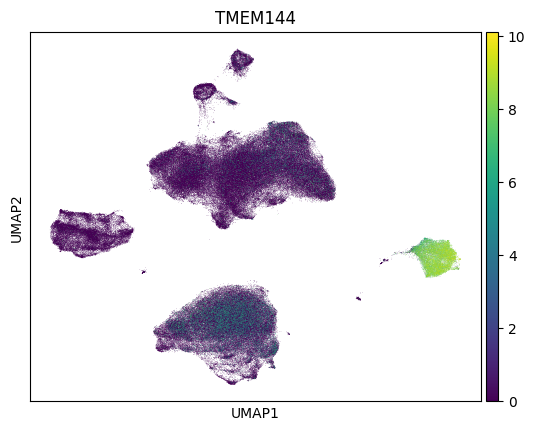

In [19]:
sc.pl.umap(adatab, color='TMEM144') #Expressed by oligo in their differentiation from OPC

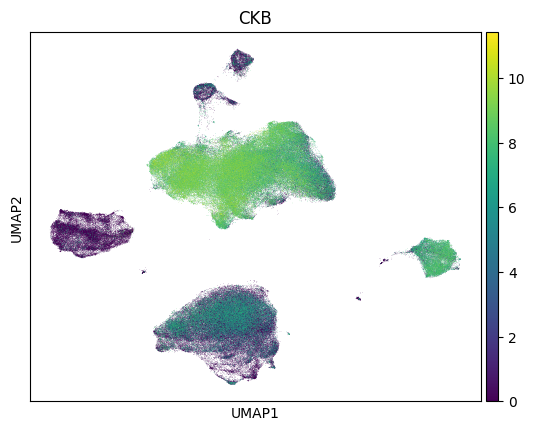

In [20]:
sc.pl.umap(adatab, color='CKB') #Possível novo marcador de glioblastoma

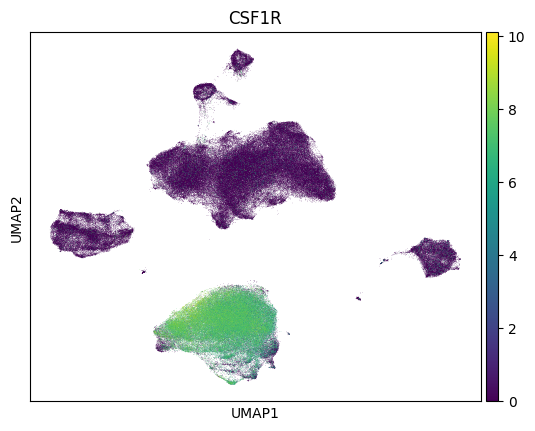

In [21]:
sc.pl.umap(adatab, color='CSF1R') #Marcador de macrófagos

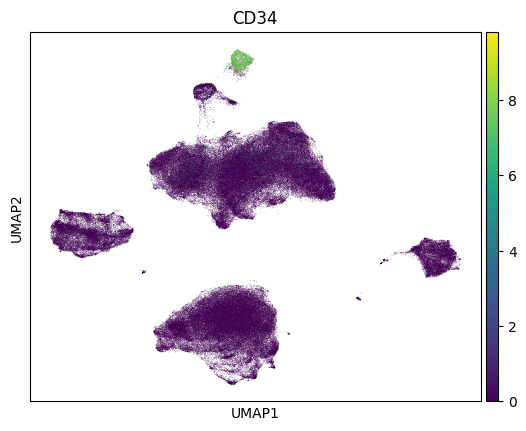

In [22]:
sc.pl.umap(adatab, color='CD34') #Marcador de células endoteliais

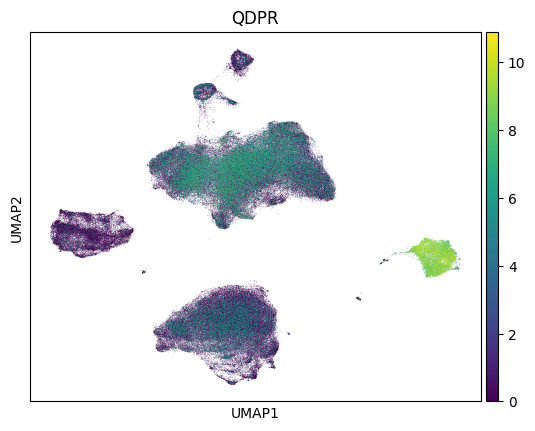

In [23]:
sc.pl.umap(adatab, color='QDPR')

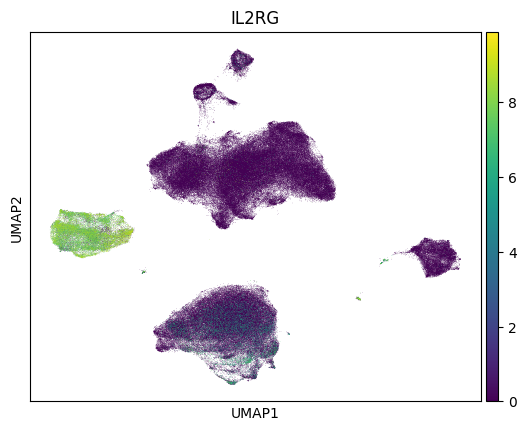

In [26]:
sc.pl.umap(adatab, color='IL2RG')

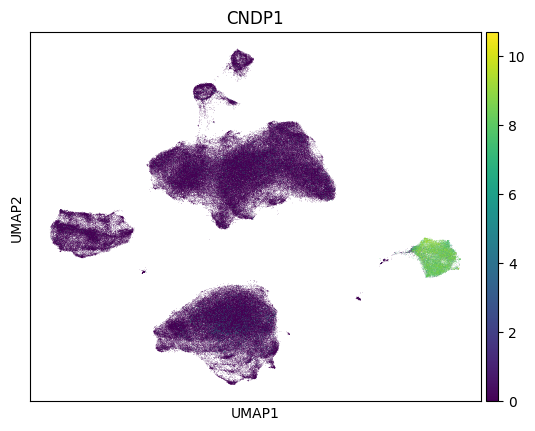

In [27]:
sc.pl.umap(adatab, color='CNDP1')

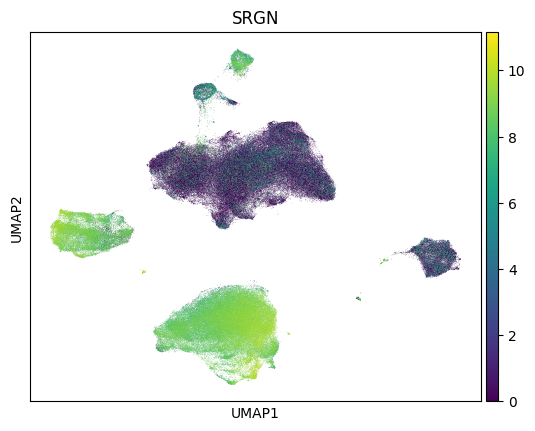

In [30]:
sc.pl.umap(adatab, color='SRGN')

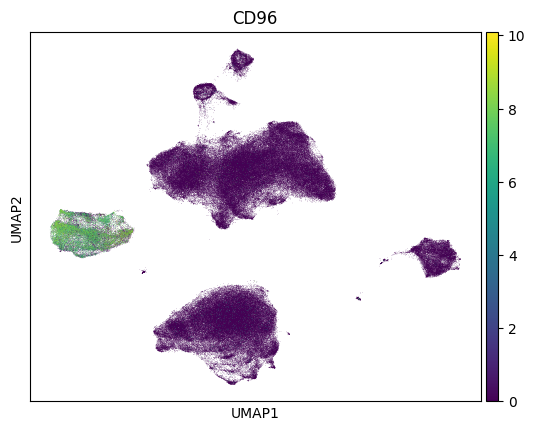

In [31]:
sc.pl.umap(adatab, color='CD96')

In [25]:
adata.var.head(10)

""
gene
TMEM144
CKB
CSF1R
CD34
QDPR
IL2RG
CNDP1
TESPA1
SRGN
